In [2]:
# !pip install openai
# !pip install tiktoken

In [3]:
import openai
import pandas as pd
import numpy as np
import tiktoken
import datetime
from IPython.display import Image

In [4]:
# f = open("/content/sample_data/OPENAI_API_KEY.txt", "r")
f = open("OPENAI_API_KEY.txt", "r")
openai_api_key = f.read()
# print(openai_api_key)
client = openai.OpenAI(api_key=openai_api_key)

In [5]:
llm_model = "gpt-3.5-turbo"

In [6]:
def get_completion_and_token_count(prompt,
                                   model=llm_model,
                                   temperature=0,
                                   max_tokens=500):
    messages = [{"role": "user", "content": prompt+' output in JSON format'}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,        # messages = [{"role": "user", "content": prompt}], a list of messages comprising the conversation so far.
        temperature=temperature,
        max_tokens=max_tokens,    # The maximum number of tokens that can be 'generated' by the chat completion.
    )

    content = response.choices[0].message.content

    token_dict = {
        'prompt_tokens':response.usage.prompt_tokens, # no. of input tokens counted by OpenAI API
        'completion_tokens':response.usage.completion_tokens,
        'total_tokens':response.usage.total_tokens,
    }
    print(response)
    print(content)
    print(token_dict)

    return response, content, token_dict

In [7]:
response, content, token_dict = get_completion_and_token_count("What is 1+1?")

ChatCompletion(id='chatcmpl-93Qo3fWHySRI5Oxp5EhyITXWGzN7u', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='{\n  "result": 2\n}', role='assistant', function_call=None, tool_calls=None))], created=1710605055, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint='fp_4f2ebda25a', usage=CompletionUsage(completion_tokens=9, prompt_tokens=18, total_tokens=27))
{
  "result": 2
}
{'prompt_tokens': 18, 'completion_tokens': 9, 'total_tokens': 27}


In [8]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
encoding.encode("What is 1+1?") # no. of input tokens counted by OpenAI API

[3923, 374, 220, 16, 10, 16, 30]

# ***Chat API : LangChain***

In [9]:
# !pip install langchain --user

In [10]:
import langchain

# Model

In [11]:
from langchain.chat_models import ChatOpenAI

In [12]:
import os
os.environ['OPENAI_API_KEY'] = openai_api_key # MUST
# To control the randomness and creativity of the generated text by an LLM, use temperature = 0.0
chat = ChatOpenAI(temperature=0.0, model=llm_model)

C:\Users\amit.tewari\AppData\Roaming\Python\Python38\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The class `langchain_community.chat_models.openai.ChatOpenAI` was deprecated in langchain-community 0.0.10 and will be removed in 0.2.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


# Prompt template - Input into the model

In [13]:
template_string = """Translate the text \
that is delimited by triple backticks \
into a style that is {style}. \
text: ```{text}```
"""

In [14]:
from langchain.prompts import ChatPromptTemplate
prompt_template = ChatPromptTemplate.from_template(template_string)

In [15]:
print(prompt_template.messages[0].prompt)
print(prompt_template.messages[0].prompt.input_variables)

input_variables=['style', 'text'] template='Translate the text that is delimited by triple backticks into a style that is {style}. text: ```{text}```\n'
['style', 'text']


In [16]:
customer_email = """
Hi how are you doing
"""
customer_style = """Spanish \
in a calm and respectful tone
"""
customer_messages = prompt_template.format_messages(
                    style=customer_style,
                    text=customer_email)

In [17]:
print(type(customer_messages))
print(customer_messages)
print(type(customer_messages[0]))
print(customer_messages[0])

<class 'list'>
[HumanMessage(content='Translate the text that is delimited by triple backticks into a style that is Spanish in a calm and respectful tone\n. text: ```\nHi how are you doing\n```\n')]
<class 'langchain_core.messages.human.HumanMessage'>
content='Translate the text that is delimited by triple backticks into a style that is Spanish in a calm and respectful tone\n. text: ```\nHi how are you doing\n```\n'


In [18]:
# Call the LLM to translate to the style of the customer message
customer_response = chat(customer_messages)

C:\Users\amit.tewari\AppData\Roaming\Python\Python38\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.7 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


In [19]:
print(customer_response.content)

Hola, ¿cómo estás?


# Parse the LLM output 

In [20]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

In [21]:
email_body_schema = ResponseSchema(name="email_body",
                                      description="Extract email body")

email_from_schema = ResponseSchema(name="email_sender",
                                      description="Extract sender email")

email_from_name_schema = ResponseSchema(name="email_sender_name",
                                      description="Extract sender name")

email_from_designation_schema = ResponseSchema(name="email_sender_designation",
                                      description="Extract sender designation")

email_from_organization_schema = ResponseSchema(name="email_sender_organization",
                                      description="Extract sender orgaization")

email_date_schema = ResponseSchema(name="email_date",
                                       description="Extract email date")

email_to_schema = ResponseSchema(name="email_recipients",
                                      description="Extract comma separated email recipients")

response_schemas = [email_from_schema,
                    email_from_name_schema,
                    email_from_designation_schema,
                    email_from_organization_schema,
                    email_to_schema,
                    email_date_schema,
                    email_body_schema]

In [22]:
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

In [23]:
format_instructions = output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"email_sender": string  // Extract sender email
	"email_sender_name": string  // Extract sender name
	"email_sender_designation": string  // Extract sender designation
	"email_sender_organization": string  // Extract sender orgaization
	"email_recipients": string  // Extract comma separated email recipients
	"email_date": string  // Extract email date
	"email_body": string  // Extract email body
}
```


In [24]:
email = "From: Doe, John <JohnDoe@xyz.com> \
Sent: Wednesday, March 15, 2023 11:21 PM \
To: Hollester, Mike <@MHollester.com>; Parrera, Nicky <NParrera@xyz.com> \
Cc: Bush, Johnny <JBush@xyz.com>; Herding, Bill <BHerding@xyz.com> \
Subject: RE: Interested in AI product  \
I hope this email finds you well. \
I am reaching out to inquire about your company's AI offerings and services. \
Could you please provide more information regarding your capabilities and solutions in this field? \
Shawn Ponting \
Senior Product Manager \
Great Corporation"

In [25]:
review_template_2 = """\
For the following text, extract the following information:

email_body: Extract email body If this information is not found,output Unknown Email Body
email_sender: Extract sender email If this information is not found, output Unknown Sender.
email_sender_designation: Extract sender designation If this information is not found, output Unknown Sender Designation.
email_sender_organization: Extract sender organization If this information is not found, output Unknown Sender Organization.
email_date: Extract email date If this information is not found, output Unknown Date.
email_recipients: Extract comma separated email recipients If this information is not found, output Unknown Recipients.

text: {text}

{format_instructions}
"""

In [26]:
prompt = ChatPromptTemplate.from_template(template=review_template_2)

messages = prompt.format_messages(text=email,
                                format_instructions=format_instructions)

In [27]:
print(messages[0].content)

For the following text, extract the following information:

email_body: Extract email body If this information is not found,output Unknown Email Body
email_sender: Extract sender email If this information is not found, output Unknown Sender.
email_sender_designation: Extract sender designation If this information is not found, output Unknown Sender Designation.
email_sender_organization: Extract sender organization If this information is not found, output Unknown Sender Organization.
email_date: Extract email date If this information is not found, output Unknown Date.
email_recipients: Extract comma separated email recipients If this information is not found, output Unknown Recipients.

text: From: Doe, John <JohnDoe@xyz.com> Sent: Wednesday, March 15, 2023 11:21 PM To: Hollester, Mike <@MHollester.com>; Parrera, Nicky <NParrera@xyz.com> Cc: Bush, Johnny <JBush@xyz.com>; Herding, Bill <BHerding@xyz.com> Subject: RE: Interested in AI product  I hope this email finds you well. I am reach

In [28]:
response = chat(messages)

In [29]:
print(response.content)

```json
{
	"email_sender": "JohnDoe@xyz.com",
	"email_sender_name": "Doe, John",
	"email_sender_designation": "Senior Product Manager",
	"email_sender_organization": "Great Corporation",
	"email_recipients": "Hollester, Mike <@MHollester.com>, Parrera, Nicky <NParrera@xyz.com>, Bush, Johnny <JBush@xyz.com>, Herding, Bill <BHerding@xyz.com>",
	"email_date": "Wednesday, March 15, 2023 11:21 PM",
	"email_body": "I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field?"
}
```


In [30]:
output_dict = output_parser.parse(response.content)

In [31]:
output_dict

{'email_sender': 'JohnDoe@xyz.com',
 'email_sender_name': 'Doe, John',
 'email_sender_designation': 'Senior Product Manager',
 'email_sender_organization': 'Great Corporation',
 'email_recipients': 'Hollester, Mike <@MHollester.com>, Parrera, Nicky <NParrera@xyz.com>, Bush, Johnny <JBush@xyz.com>, Herding, Bill <BHerding@xyz.com>',
 'email_date': 'Wednesday, March 15, 2023 11:21 PM',
 'email_body': "I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field?"}

# LangChain: Memory

### Memory of history in a chat keeps on appending by Langchain!

In [32]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory

In [33]:
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=llm, 
    memory = memory,
    verbose=True
)

In [34]:
conversation.predict(input="Hi, this is a LangChain tutorial to explain Memory for chat application")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI:

> Finished chain.


"Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared between users. This can include things like chat history, user preferences, and personalized recommendations based on previous conversations. Memory is essential for creating a seamless and personalized user experience in chat applications. Is there anything specific you would like to know about Memory in chat applications?"

In [35]:
conversation.predict(input="I will use simple examples to explain Langchain Memory ")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared between users. This can include things like chat history, user preferences, and personalized recommendations based on previous conversations. Memory is essential for creating a seamless and personalized user experience in chat applications. Is there anything specific you would like to know about Memory in chat applications?
Human: I will use simple examples to explain Langchain Memory 
AI:

> Fini

'That sounds like a great approach! Using simple examples can make it easier for users to understand how LangChain Memory works. Feel free to provide any examples or scenarios you have in mind, and I can help explain how Memory would be applied in those situations. Let me know how I can assist you further!'

In [36]:
conversation.predict(input="What are we going to learn in this tutorial?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared between users. This can include things like chat history, user preferences, and personalized recommendations based on previous conversations. Memory is essential for creating a seamless and personalized user experience in chat applications. Is there anything specific you would like to know about Memory in chat applications?
Human: I will use simple examples to explain Langchain Memory 
AI: That so

"In this tutorial, we will learn about the importance of Memory in chat applications, how it enhances user experience, and how LangChain utilizes Memory to improve interactions between users. We will also explore different examples and scenarios to illustrate how Memory can be implemented effectively in chat applications. Additionally, we will discuss best practices for managing and utilizing Memory in a way that benefits both users and developers. I hope this overview gives you a good idea of what to expect in this tutorial! If you have any specific questions or topics you'd like to focus on, feel free to let me know."

In [37]:
print(memory.buffer) # History

Human: Hi, this is a LangChain tutorial to explain Memory for chat application
AI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared between users. This can include things like chat history, user preferences, and personalized recommendations based on previous conversations. Memory is essential for creating a seamless and personalized user experience in chat applications. Is there anything specific you would like to know about Memory in chat applications?
Human: I will use simple examples to explain Langchain Memory 
AI: That sounds like a great approach! Using simple examples can make it easier for users to understand how LangChain Memory works. Feel free to provide any examples or scenarios you have in mind, and I can help explain how Memory would be applied in those situations. Let me know how I can assist you further!
Human: What are we goin

In [38]:
# Provide additional context 
today_date = str(datetime.date.today())
memory.save_context({"input": "What is the date today?" }, 
                    {"output": today_date}) 

In [39]:
memory.load_memory_variables({})

{'history': "Human: Hi, this is a LangChain tutorial to explain Memory for chat application\nAI: Hello! I'm excited to help you understand Memory for chat applications. Memory in this context refers to the ability of the chat application to remember past interactions and information shared between users. This can include things like chat history, user preferences, and personalized recommendations based on previous conversations. Memory is essential for creating a seamless and personalized user experience in chat applications. Is there anything specific you would like to know about Memory in chat applications?\nHuman: I will use simple examples to explain Langchain Memory \nAI: That sounds like a great approach! Using simple examples can make it easier for users to understand how LangChain Memory works. Feel free to provide any examples or scenarios you have in mind, and I can help explain how Memory would be applied in those situations. Let me know how I can assist you further!\nHuman:

In [40]:
# Remember just 'LAST K converstaions' instead of entire history to avoid sending entire conversation to OpenAI API
from langchain.memory import ConversationBufferWindowMemory
memory = ConversationBufferWindowMemory(k=1)               

In [41]:
# Provide additional context 
today_date = str(datetime.date.today())
memory.save_context({"input": "What is your City of residenc?" }, 
                    {"output": "Delhi"}) 
memory.save_context({"input": "What is your Country of residence?" }, 
                    {"output": "India"}) 

In [42]:
memory.load_memory_variables({})

{'history': 'Human: What is your Country of residence?\nAI: India'}

In [43]:
# llm = ChatOpenAI(temperature=0.0, model=llm_model)
# memory =  ConversationBufferWindowMemory(k=1)  # usage
# conversation = ConversationChain(
#     llm=llm, 
#     memory = memory,
#     verbose=True
# )

In [44]:
# Limit the # of tokens to send instead of entire history
from langchain.memory import ConversationTokenBufferMemory
from langchain.llms import OpenAI
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [45]:
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=20)
memory.save_context({"input": "What is your City of residence?" }, 
                    {"output": "Delhi"}) 
memory.save_context({"input": "What is your Country of residence?" }, 
                    {"output": "India"})
memory.save_context({"input": "Which city is your office located?" }, 
                    {"output": "New York"})

In [46]:
memory.load_memory_variables({})

{'history': 'AI: New York'}

In [47]:
# Instead of limiting fixed # of token, lets use LLM to write the summary of conversation so far and remem the summary
from langchain.memory import ConversationSummaryBufferMemory
memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=30) 
# entire hostory so far will be summarized in max 30 token 
memory.save_context({"input": "What is your City of residence?" }, 
                    {"output": "Delhi"}) 
memory.save_context({"input": "What is your Country of residence?" }, 
                    {"output": "India"})
memory.save_context({"input": "Which city is your office located?" }, 
                    {"output": "New York"})
memory.save_context({"input": "What is the date today?" }, 
                    {"output": today_date}) 

In [48]:
memory.load_memory_variables({})

{'history': 'System: The human asks the AI what its City of residence is, to which the AI responds "Delhi." The human then asks the AI for its Country of residence, to which the AI responds "India." When asked about the city where its office is located, the AI answers "New York."\nHuman: What is the date today?\nAI: 2024-03-16'}

In [49]:
conversation = ConversationChain(
    llm=llm, 
    memory = memory,
    verbose=True
)

In [50]:
# Q/A or chat using history/memory 
conversation.predict(input="What is the office location city?") 



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: The human asks the AI what its City of residence is, to which the AI responds "Delhi." The human then asks the AI for its Country of residence, to which the AI responds "India." When asked about the city where its office is located, the AI answers "New York."
Human: What is the date today?
AI: 2024-03-16
Human: What is the office location city?
AI:

> Finished chain.


'New York'

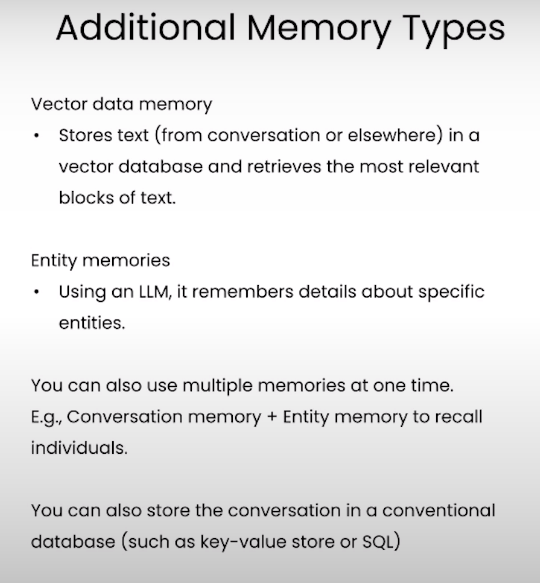

In [51]:
Image(filename='img1.png') 

# LLM Chains

In [52]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [53]:
llm = ChatOpenAI(temperature=0.0, model=llm_model)

In [54]:
email = "From: Ponting, Shawn <SPonting@abc.com> \
Sent: Wednesday, March 15, 2023 11:21 PM \
To: Hollester, Mike <MHollester@xyz.com> \
Subject: RE: Interested in AI product  \
I hope this email finds you well. \
I am reaching out to inquire about your company's AI offerings and services. \
Could you please provide more information regarding your capabilities and solutions in this field? \
Shawn Ponting \
Senior Product Manager \
Great Corporation"

In [55]:
prompt = ChatPromptTemplate.from_template(
    "Extract sender email from {email}?"
)

In [56]:
chain = LLMChain(llm=llm, prompt=prompt)

In [57]:
chain.run(email)

C:\Users\amit.tewari\AppData\Roaming\Python\Python38\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


'SPonting@abc.com'

In [58]:
# SimpleSequentialChain output of first chain is passed as input to second chain
from langchain.chains import SimpleSequentialChain
llm = ChatOpenAI(temperature=0.9, model=llm_model)

# prompt template 1
first_prompt = ChatPromptTemplate.from_template(
    "Extract sender details from {email}?"
)

# Chain 1
chain_one = LLMChain(llm=llm, prompt=first_prompt)

In [59]:
# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Extract sender email from {response}?"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt)

In [60]:
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two],
                                             verbose=True
                                            )

In [61]:
overall_simple_chain.run(email)



> Entering new SimpleSequentialChain chain...
Sender details extracted:

Sender Name: Shawn Ponting
Sender Email: SPonting@abc.com
Position: Senior Product Manager
Company: Great Corporation
The sender email extracted is SPonting@abc.com.

> Finished chain.


'The sender email extracted is SPonting@abc.com.'

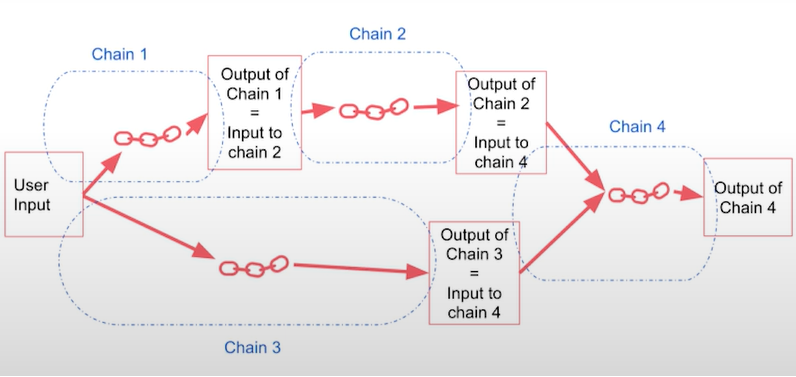

In [62]:
Image(filename='img2.png') 

In [63]:
# SequentialChain - If multiple inputs and outputs and take inputs from previous chain and pass as outputs to next chain
from langchain.chains import SequentialChain
llm = ChatOpenAI(temperature=0.0, model=llm_model)

# prompt template 1: 
first_prompt = ChatPromptTemplate.from_template(
    "Extract sender details from {email}"
)
# chain 1: 
chain_one = LLMChain(llm=llm, prompt=first_prompt, 
                     output_key="sender_details"
                    )

# prompt template 2
second_prompt = ChatPromptTemplate.from_template(
    "Extract receiver details from {email}"
)
# chain 2
chain_two = LLMChain(llm=llm, prompt=second_prompt,
                    output_key="receiver_details")

# prompt template 3
third_prompt = ChatPromptTemplate.from_template(
    "Draft reply using context provided in email using sender and receiver details: "
    "\n\sender: {receiver_details}\n\nreceiver: {sender_details}\n\nemail: {email}"
)
# chain 3
chain_three = LLMChain(llm=llm, prompt=third_prompt,
                    output_key="reply")

# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three],
    input_variables=["email"],
    output_variables=["receiver_details", "sender_details","reply"],
    verbose=True
)

In [64]:
overall_chain(email)



> Entering new SequentialChain chain...


C:\Users\amit.tewari\AppData\Roaming\Python\Python38\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(



> Finished chain.


{'email': "From: Ponting, Shawn <SPonting@abc.com> Sent: Wednesday, March 15, 2023 11:21 PM To: Hollester, Mike <MHollester@xyz.com> Subject: RE: Interested in AI product  I hope this email finds you well. I am reaching out to inquire about your company's AI offerings and services. Could you please provide more information regarding your capabilities and solutions in this field? Shawn Ponting Senior Product Manager Great Corporation",
 'receiver_details': 'Receiver details:\nName: Mike Hollester\nEmail: MHollester@xyz.com',
 'sender_details': 'Sender details:\nName: Shawn Ponting\nEmail: SPonting@abc.com\nPosition: Senior Product Manager\nCompany: Great Corporation',
 'reply': 'From: Hollester, Mike <MHollester@xyz.com>\nSent: Thursday, March 16, 2023 9:00 AM\nTo: Ponting, Shawn <SPonting@abc.com>\nSubject: Re: Interested in AI product\n\nHello Shawn,\n\nThank you for reaching out and expressing interest in our AI offerings. I would be happy to provide you with more information regardi

# LangChain: Q&A over Documents

In [68]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import CSVLoader
# In-memory vector store for doesnt require connetng with external vector databases - good starting point for small datasets
from langchain.vectorstores import DocArrayInMemorySearch 
from IPython.display import display, Markdown
from langchain.llms import OpenAI

In [66]:
file = 'all_short_clauses_test.csv'
loader = CSVLoader(file_path=file)

In [ ]:
!pip install sqlalchemy

In [69]:
from langchain.indexes import VectorstoreIndexCreator

ImportError: cannot import name 'URL' from 'sqlalchemy' (C:\ProgramData\Anaconda3\lib\site-packages\sqlalchemy\__init__.py)